In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from beamline34IDC.simulation.facade import Implementors
from beamline34IDC.simulation.facade.focusing_optics_factory import focusing_optics_factory_method
from beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
from beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
from beamline34IDC.util.redirect_shadow_output import redirected_output

In [3]:
%matplotlib inline

In [4]:
DEFAULT_RANDOM_SEED = 111

In [40]:
def getBeam(random_seed=DEFAULT_RANDOM_SEED, remove_lost_rays=True, redirect_output=True):
    global focusing_system
    if redirect_output:
        with redirected_output():
            out_beam = focusing_system.get_photon_beam(random_seed=random_seed, remove_lost_rays=remove_lost_rays)
    else:
        out_beam = focusing_system.get_photon_beam(random_seed=random_seed, remove_lost_rays=remove_lost_rays)
    return out_beam


def getPeakIntensity(random_seed=DEFAULT_RANDOM_SEED, redirect_output=True):
    try:
        out_beam = getBeam(random_seed=random_seed, redirect_output=redirect_output)
    except EmptyBeamException:
        # Assuming that the beam is outside the screen and returning 0 as a default value.
        return 0
    _, dw = get_shadow_beam_spatial_distribution(out_beam)
    peak = dw.get_parameter('peak_intensity')
    return peak, out_beam, hist, dw

def getCentroidDistance(random_seed=DEFAULT_RANDOM_SEED, redirect_output=True):
    global focusing_system
    try:
        out_beam = getBeam(random_seed=random_seed, redirect_output=redirect_output)
    except EmptyBeamException:
        # Assuming that the centroid is outside the screen and returning 0.5 microns as a default value.
        return 0.5, 
    hist, dw = get_shadow_beam_spatial_distribution(out_beam)
    h_centroid = dw.get_parameter('h_centroid')
    v_centroid = dw.get_parameter('v_centroid')
    centroid_distance = (h_centroid ** 2 + v_centroid ** 2) ** 0.5
    return centroid_distance, out_beam, hist, dw


def moveRelative(trans):
    global focusing_system
    focusing_system.move_hkb_motor_4_translation(trans, movement=Movement.RELATIVE)


def moveAbsolute(trans):
    global focusing_system
    focusing_system.move_hkb_motor_4_translation(trans, movement=Movement.ABSOLUTE)


def lossFunction(trans, random_seed=DEFAULT_RANDOM_SEED, redirect_output=True, movement='relative', verbose=True):
    global focusing_system
    if movement == 'relative':
        moveRelative(trans)
    elif movement == 'absolute':
        moveAbsolute(trans)
    else:
        raise ValueError
    centroid_distance, *__ = getCentroidDistance(random_seed=random_seed, redirect_output=redirect_output)
    if verbose:
        print("trans", trans, "current loss", centroid_distance)
    return centroid_distance


def reinitialize(random_seed=DEFAULT_RANDOM_SEED, remove_lost_rays=True):
    clean_up()
    focusing_system = focusing_optics_factory_method(implementor=Implementors.SHADOW)

    focusing_system.initialize(input_photon_beam=input_beam,
                               rewrite_preprocessor_files=PreProcessorFiles.NO,
                               rewrite_height_error_profile_files=False)
    # Not redirecting the output for the initialization step, just in case there are any errors.
    output_beam = focusing_system.get_photon_beam(random_seed=random_seed, remove_lost_rays=remove_lost_rays)
    return focusing_system, output_beam


class OptimizationLossFunction:
    def __init__(self):
        self.x_absolute_prev = 0
        
    def loss(self, x_absolute_this, verbose=False):
        x_relative_this = x_absolute_this - self.x_absolute_prev
        self.x_absolute_prev = x_absolute_this
        return lossFunction(x_relative_this, verbose=verbose)
    
def optimizationTrials(initial_absolute_movement, n_guesses=5, verbose=False):
    guesses_all = []
    for n_trial in range(n_guesses):
        guess_this = np.random.uniform(-0.05, 0.05)
        lossfn_obj = OptimizationLossFunction()
        lossfn = lambda x: lossfn_obj.loss(x, verbose=verbose)
        opt = scipy.optimize.minimize(lossfn, [guess_this], 
                                      method='Nelder-Mead', 
                                      options={'maxiter':50, 'adaptive':True})
        guesses_all.append(guess_this)
        if opt.fun < 5e-4:
            return guesses_all, True
        moveAbsolute(initial_absolute_movement)
        centroid, out_beam, *_ = getCentroidDistance()
        
    return guesses_all, False

In [6]:
work_dir = '/Users/saugat/code/oasys/ML_Control_System/work_directory'
os.chdir(work_dir)
input_beam = load_shadow_beam("primary_optics_system_beam.dat")

In [7]:
fig_save_path = 'figures/opt_hkb_mot4_only/'

In [11]:
if not os.path.isdir(fig_save_path):
    print("Fig save directory does not exist. Trying to create.")
    os.mkdir(fig_save_path)

In [12]:
# Focusing Optics System -------------------------
with redirected_output():
    focusing_system, out_beam = reinitialize()

trans 0.0 current loss 7.625219885299723e-05
7.625219885299723e-05 7.625219885299723e-05


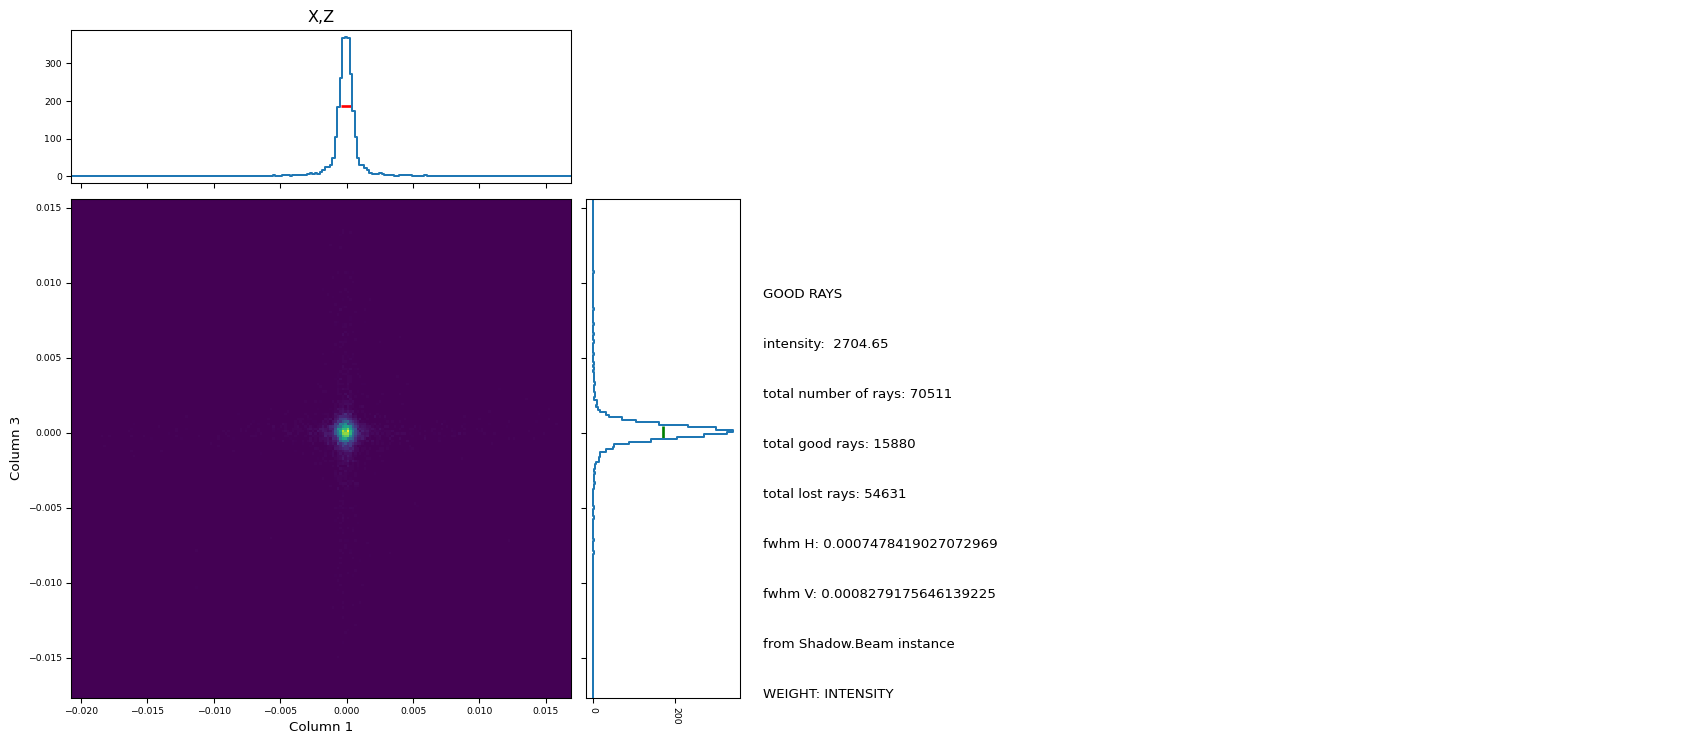

In [13]:
centroid, out_beam, hist, dw = getCentroidDistance()
print(centroid, lossFunction(0.))
_ = plot_shadow_beam_spatial_distribution(out_beam)

In [41]:
initial_centroids = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_centroids = []
final_out_beams = []

for outer in tqdm(range(10)):
    movement = np.random.uniform(-0.14, 0.14)
    moveAbsolute(movement)
    centroid, out_beam, *_ = getCentroidDistance()
    absolute_movements.append(movement)
    initial_centroids.append(centroid)
    initial_out_beams.append(out_beam)

    guesses_all, success = optimizationTrials(movement, 5, verbose=True)
    start_guesses.append(guesses_all)
    overall_successes.append(success)
    centroid, out_beam, *_ = getCentroidDistance()
    final_centroids.append(centroid)
    final_out_beams.append(out_beam)
    print(f'Test {outer} success {success}')
    

  0%|                                                                                                           | 0/10 [00:00<?, ?it/s]

trans [0.04199632] current loss 0.039565183919998775
trans [0.00209982] current loss 0.04166102509541501
trans [-0.00419963] current loss 0.03746725334538758
trans [-0.00419963] current loss 0.03327511340080538
trans [-0.00629945] current loss 0.02698414294536637
trans [-0.0125989] current loss 0.014476645831842768
trans [-0.01889834] current loss 0.0043884038404192905
trans [-0.03779669] current loss 0.04213567665325352
trans [0.01889834] current loss 0.023290346384228666
trans [0.02362293] current loss 0.0003393962449798149
trans [0.00472459] current loss 0.0050540366293609735
trans [-0.00590573] current loss 0.0008462292810608164
trans [0.00236229] current loss 0.001516337300675701
trans [-0.00147643] current loss 6.316558702605698e-05
trans [-0.00029529] current loss 0.0002575095439717366
trans [0.00022146] current loss 5.713027099948477e-05


 10%|█████████▉                                                                                         | 1/10 [00:28<04:18, 28.71s/it]

Test 0 success True
trans [-0.03316653] current loss 0.050053898038510194
trans [-0.00165833] current loss 0.04840109218341515
trans [-0.00165833] current loss 0.046747151363057925
trans [-0.00331665] current loss 0.04343812224821279
trans [-0.00497498] current loss 0.038469438260386145
trans [-0.00994996] current loss 0.028536594959374967
trans [-0.01492494] current loss 0.013707063417535427
trans [-0.02984988] current loss 0.016118429179397417
trans [0.01492494] current loss 0.0011893890384164398
trans [-0.02984988] current loss 0.031017818028086702
trans [0.01492494] current loss 0.016118429179397417
trans [0.01865617] current loss 0.0025406382397384726
trans [-0.00746247] current loss 0.0049202346556004905
trans [0.00466404] current loss 0.0002584546377969543
trans [0.00093281] current loss 0.0006778596407413206
trans [-0.00069961] current loss 5.175755014518416e-05
trans [0.0002332] current loss 0.00021698635401883756
trans [-0.0001749] current loss 6.02604235332976e-05


 20%|███████████████████▊                                                                               | 2/10 [01:01<04:08, 31.02s/it]

Test 1 success True
trans [-0.00033471] current loss 0.1241304982402732
trans [-1.67355176e-05] current loss 0.12399768808074647
trans [-1.67355176e-05] current loss 0.12398879832151138
trans [-3.34710351e-05] current loss 0.1240191474010746
trans [0.01390731] current loss 0.13802563545161184
trans [0.00069537] current loss 0.13832892813499667
trans [-0.00139073] current loss 0.13730300462852504
trans [-0.00139073] current loss 0.13577347989823893
trans [-0.0020861] current loss 0.13374033048673867
trans [-0.00417219] current loss 0.12985089558333757
trans [-0.00625829] current loss 0.12370443586446675
trans [-0.01251657] current loss 0.11129777480989064
trans [-0.01877486] current loss 0.09274135432261844
trans [-0.03754972] current loss 0.055320055839549784
trans [-0.05632459] current loss 0.0008249391113265763
trans [-0.11264917] current loss 0.11334046482719229
trans [0.05632459] current loss 0.05706609562873427
trans [0.07040573] current loss 0.013230991397157584
trans [-0.0281622

 30%|█████████████████████████████▋                                                                     | 3/10 [01:47<04:25, 37.98s/it]

Test 2 success True
trans [0.02126791] current loss 0.13591855888523915
trans [0.0010634] current loss 0.13681596235193874
trans [-0.00212679] current loss 0.13477282789247297
trans [-0.00212679] current loss 0.13266062338324075
trans [-0.00319019] current loss 0.12954239099101325
trans [-0.00638037] current loss 0.12345886121640338
trans [-0.00957056] current loss 0.11393288806151276
trans [-0.01914112] current loss 0.09489866025152634
trans [-0.02871168] current loss 0.06634468639907168
trans [-0.05742337] current loss 0.009122165274006016
trans [-0.08613505] current loss 0.07688219051655054
trans [0.06460129] current loss 0.012399142941200772
trans [0.04306753] current loss 0.030542697991495837
trans [-0.0269172] current loss 0.003753662738378908
trans [-0.00538344] current loss 0.0016310239789085405
trans [-0.01076688] current loss 0.012399142941200772
trans [0.00538344] current loss 0.007015466757390885
trans [0.0067293] current loss 0.00028496766149004987
trans [0.00134586] curre

 40%|███████████████████████████████████████▌                                                           | 4/10 [02:26<03:50, 38.37s/it]

Test 3 success True
trans [-0.03647896] current loss 0.03897266237993035
trans [-0.00182395] current loss 0.04079137617087295
trans [0.0036479] current loss 0.03715270116958447
trans [0.0036479] current loss 0.033515703642755156
trans [0.00547184] current loss 0.02805846039333235
trans [0.01094369] current loss 0.017135548539177786
trans [0.01641553] current loss 0.0007114355692634049
trans [0.03283107] current loss 0.03199070257846188
trans [-0.01641553] current loss 0.015668512527329266
trans [-0.01231165] current loss 0.003391466162376566
trans [-0.00820777] current loss 0.00481464258301701
trans [0.00512985] current loss 0.0003191094770420625
trans [0.00102597] current loss 0.001339215243916977
trans [-0.00128246] current loss 7.648230459665673e-05
trans [-0.00025649] current loss 0.00020195413025661087
trans [0.00019237] current loss 4.7226517143683255e-05


 50%|█████████████████████████████████████████████████▌                                                 | 5/10 [02:56<02:57, 35.40s/it]

Test 4 success True
trans [-0.03879581] current loss 0.028329919462918202
trans [-0.00193979] current loss 0.030264895526643833
trans [0.00387958] current loss 0.02639772126861306
trans [0.00387958] current loss 0.022531054959129784
trans [0.00581937] current loss 0.01671236722112892
trans [0.01163874] current loss 0.005066248829997954
trans [0.01745812] current loss 0.012370183705260551
trans [-0.01309359] current loss 0.0007016814238909233
trans [0.00436453] current loss 0.003662517374483455
trans [-0.0032734] current loss 0.00039284846803213356
trans [0.00109113] current loss 0.0014803414265742124
trans [-0.00136392] current loss 0.00012765352032590766
trans [-0.00027278] current loss 0.00016125591184652796
trans [0.00020459] current loss 6.910112667676145e-05


 60%|███████████████████████████████████████████████████████████▍                                       | 6/10 [03:23<02:10, 32.60s/it]

Test 5 success True
trans [0.04191701] current loss 0.013076640634901724
trans [0.00209585] current loss 0.010980017414733206
trans [0.00209585] current loss 0.008881265392856212
trans [0.0041917] current loss 0.00468755777073951
trans [0.00628755] current loss 0.0015982176149749888
trans [0.0125751] current loss 0.0141417961669583
trans [-0.00628755] current loss 0.007875406423554599
trans [-0.00785944] current loss 5.521735806205947e-05
trans [-0.00157189] current loss 0.0015461529523700106
trans [0.00117892] current loss 0.0003671595209980864
trans [0.00078594] current loss 0.0004226736944152009
trans [-0.00049121] current loss 8.450468001418972e-05


 70%|█████████████████████████████████████████████████████████████████████▎                             | 7/10 [03:47<01:29, 29.79s/it]

Test 6 success True
trans [0.04212964] current loss 0.010524016770982103
trans [0.00210648] current loss 0.012629202944002157
trans [-0.00421296] current loss 0.00842641828797503
trans [-0.00421296] current loss 0.004224060105401438
trans [-0.00631945] current loss 0.0020954451555675675
trans [-0.01263889] current loss 0.014737799445799487
trans [0.00631945] current loss 0.008413614244963409
trans [0.00789931] current loss 0.0005134416815645402
trans [0.00157986] current loss 0.0010653488889138972
trans [-0.0011849] current loss 0.00012587560480100874
trans [0.00039497] current loss 0.00028118542437987964
trans [-0.00029622] current loss 5.0619156693546814e-05


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 8/10 [04:12<00:56, 28.02s/it]

Test 7 success True
trans [0.01880827] current loss 0.11127972266231083
trans [0.00094041] current loss 0.11034059245936292
trans [0.00094041] current loss 0.10940139880347306
trans [0.00188083] current loss 0.10752279475775156
trans [0.00282124] current loss 0.10470402313179485
trans [0.00564248] current loss 0.09906671389501277
trans [0.00846372] current loss 0.09061594173592477
trans [0.01692744] current loss 0.0737099396422387
trans [0.02539117] current loss 0.0483644016128827
trans [0.05078233] current loss 0.0023505424652820743
trans [0.0761735] current loss 0.07826669596631926
trans [-0.09521687] current loss 0.0166978240808739
trans [0.03808675] current loss 0.021346601245314702
trans [-0.02380422] current loss 0.0024099480267682676
trans [0.00952169] current loss 0.00710410930991055
trans [-0.00595105] current loss 0.0011616065696045436
trans [-0.00119021] current loss 5.389634436251435e-05
trans [-0.00238042] current loss 0.0024099480267682676
trans [0.00119021] current loss 

 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 9/10 [04:51<00:31, 31.67s/it]

Test 8 success True
trans [-0.02763698] current loss 0.08416060455578987
trans [-0.00138185] current loss 0.08278368288899965
trans [-0.00138185] current loss 0.08140694135241289
trans [-0.0027637] current loss 0.07865292523209824
trans [-0.00414555] current loss 0.0745244248635293
trans [-0.00829109] current loss 0.0662610493146162
trans [-0.01243664] current loss 0.05386424109412019
trans [-0.02487328] current loss 0.029041381966846073
trans [-0.03730992] current loss 0.008142776273724459
trans [-0.07461984] current loss 0.08263902004439135
trans [0.03730992] current loss 0.04539541781828509
trans [0.0466374] current loss 0.0011839248649625003
trans [0.00932748] current loss 0.01049111872614736
trans [-0.01165935] current loss 0.001147767293828087
trans [-0.00233187] current loss 0.0034790324740539167
trans [0.00291484] current loss 0.0005635646319507975
trans [0.00058297] current loss 5.1593447740635324e-05
trans [0.00116593] current loss 0.0011839248649625003
trans [-0.00058297] cu

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:31<00:00, 33.13s/it]

Test 9 success True


In [42]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [43]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [44]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [45]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

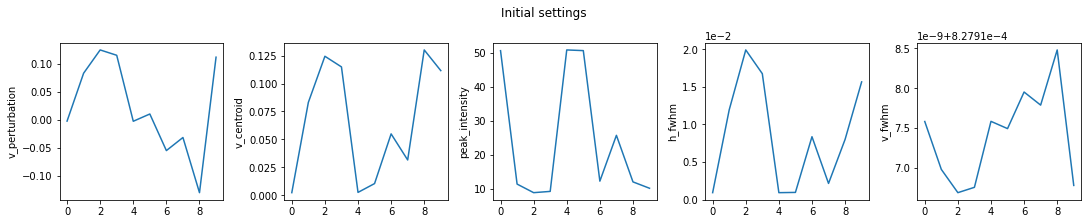

In [46]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_movements)
axes[0].set_ylabel('v_perturbation')

axes[1].plot(initial_centroids)
axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/hkb_4_initial_metrics.png', bbox_inches='tight')

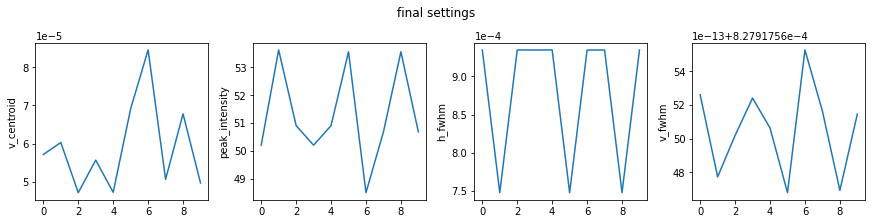

In [47]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

axes[0].plot(final_centroids)
axes[0].set_ylabel('v_centroid')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/hkb_4_final_metrics.png', bbox_inches='tight')

/Applications/Oasys1.2.app/Contents/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


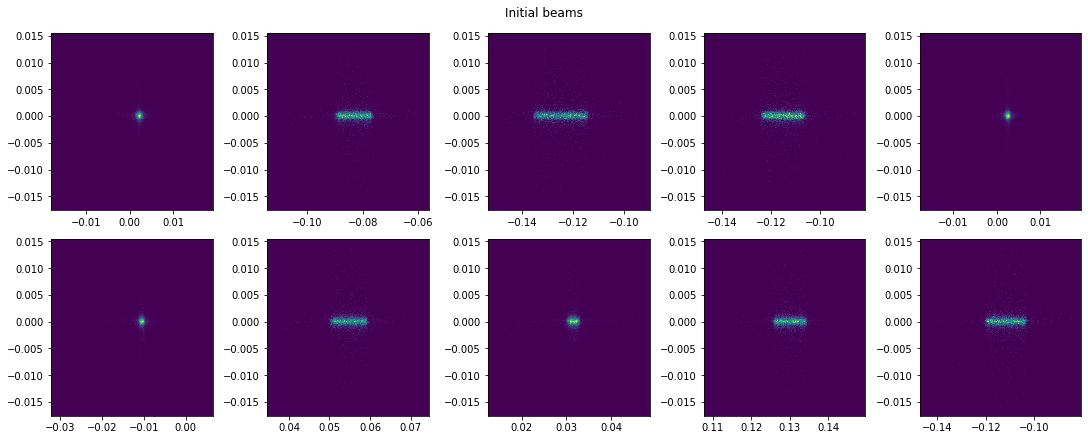

In [48]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D.T)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/hkb_4_initial_beams.png', bbox_inches='tight')

/Applications/Oasys1.2.app/Contents/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


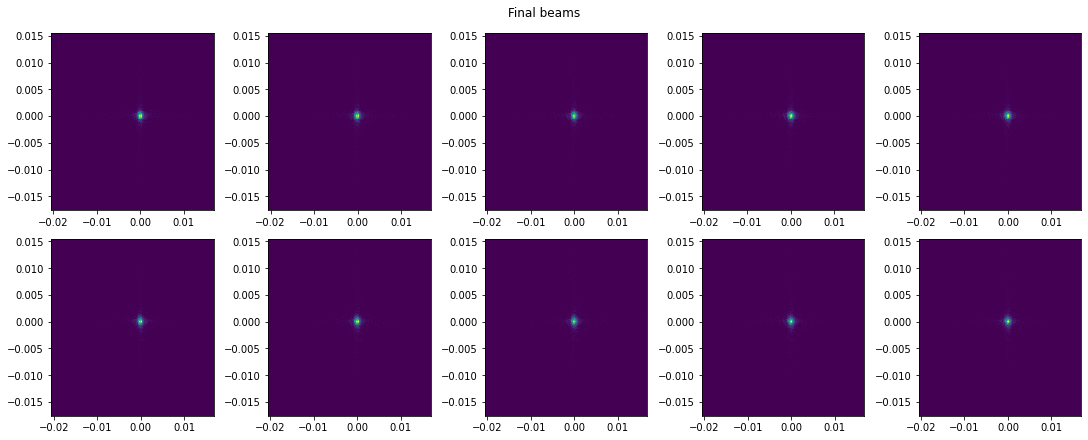

In [49]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D.T)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/hkb_4_final_beams.png', bbox_inches='tight')

In [50]:
clean_up()